In [226]:
import pandas as pd
import numpy as np
import dill
import torch.nn as nn
import torch
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import os
import Graphs
import networkx as nx
import torch.optim as optim
import random
import copy
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.optimizer import required
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
bkdatafolder = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/BKDataCleaned/"
dataset_name = os.listdir(bkdatafolder)

In [169]:
def createDictFloor(floor_name):
    getdict = {}
    floors = [floor for floor in dataset_name if floor_name in floor]
    for name in floors:
        floorname = name.split(".")[0]
        getdict[floorname] = pd.read_csv(bkdatafolder+name, index_col=0, parse_dates=["Date"])
        getdict[floorname] = getdict[floorname].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def createPlot(date1, date2, features, data):
    for floor in data.keys():
        data[floor].resample("5T").mean()[features][date1:date2].plot(figsize=(20,7))
        

def createDTFeat(date1, date2, datadict, features, resample_method="sum" ,scale=True):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for data in datadict.keys():
        if resample_method == "sum":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").sum()
            
        elif resample_method == "max":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").max().bfill()
        elif resample_method == "mean":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").mean().bfill()
            
        cols = resample_move[data].columns
        idx = resample_move[data].index

        if scale:
            
            scaler = MinMaxScaler(feature_range=(0.2,1))
            scaler.fit(resample_move[data])
            resample_move[data] = pd.DataFrame(scaler.transform(
                resample_move[data]),columns=cols,index=idx)
            
            scalers[data] = scaler

        resample_move[data]["weekday"] = resample_move[data].index.day_name()
        resample_move[data]["date"] = resample_move[data].index.date
        resample_move[data]["time"] = resample_move[data].index.time

        nan = np.where(pd.isnull(resample_move[data][features]))[0]
        index_nan[data] = np.unique(resample_move[data].iloc[nan]["time"])

    return resample_move, scalers, index_nan

def getInfoTimeShape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [170]:
date1 = "2019-03-07"
date2 = "2019-12-31"
floor = 7
floor_dict = createDictFloor(f"Floor{floor}")
for data in floor_dict.keys():
    zone = floor_dict[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("")

Floor7Z4 Start: 2019-03-06 14:46:00 End: 2019-12-31 23:59:00 Count:416243

Floor7Z5 Start: 2019-03-06 14:55:00 End: 2019-12-31 23:59:00 Count:407698

Floor7Z2 Start: 2019-03-06 14:48:00 End: 2019-12-31 23:59:00 Count:424701

Floor7Z1 Start: 2019-03-06 14:50:00 End: 2019-12-31 23:59:00 Count:424099



In [171]:
feature = "temperature"
resample_method = "max"
resample,scalers, index_nan = createDTFeat(date1, date2, floor_dict, feature,resample_method=resample_method)
cleanedData, remain_date = cleanNan(resample, index_nan)

In [172]:
getInfoTimeShape(cleanedData)

Floor : Floor7Z4 , shape :(86400, 9) , TimeMin 2019-03-07 00:00:00 , TimeMax 2019-12-31 23:55:00
Empty DataFrame
Columns: [Total, Pourcentage]
Index: [] 

Floor : Floor7Z5 , shape :(86400, 9) , TimeMin 2019-03-07 00:00:00 , TimeMax 2019-12-31 23:55:00
Empty DataFrame
Columns: [Total, Pourcentage]
Index: [] 

Floor : Floor7Z2 , shape :(86400, 9) , TimeMin 2019-03-07 00:00:00 , TimeMax 2019-12-31 23:55:00
Empty DataFrame
Columns: [Total, Pourcentage]
Index: [] 

Floor : Floor7Z1 , shape :(86400, 9) , TimeMin 2019-03-07 00:00:00 , TimeMax 2019-12-31 23:55:00
Empty DataFrame
Columns: [Total, Pourcentage]
Index: [] 



# Create Slice

In [173]:
def rolling_window(series, window_size):
    return np.array([series[i : (i + window_size)] for i in range(0, series.shape[0] - window_size + 1)])

def to_timeseries_input(series, lookback, predictions):
    inputs = rolling_window(series[:-predictions], lookback)
    outputs = rolling_window(series[lookback:], predictions)
    return inputs, outputs

def createDataByDate(datadict, features, dates):
    databyDate = defaultdict(lambda : defaultdict(dict))
    for date in dates:
        for floor in datadict.keys():
            databyDate[date][floor] = np.asarray(datadict[floor][date][features])
    return databyDate

def splitDate(dates,cutoff):
    train_date = [x for x in dates if x <= cutoff]
    test_date = sorted(list(set(dates) - set(train_date)))
    return train_date, test_date

def getInfoDataByDate(data, dates):
    for date in dates:
        print("Date : {}".format(date))
        for floor in data[date]:
            print("{} shape : {}".format(floor,data[date][floor].shape))
            
def LoaderByZone(data,zone_name,dates, lookback, lookahead, batch_size, shuffle=False):
    loaderZ = {}
    for i,date in enumerate(dates):
        haruharu = data[date][zone_name]
        trainx, trainy = to_timeseries_input(haruharu, lookback, lookahead)
        xshape = torch.tensor(trainx, dtype=torch.float).unsqueeze(-1)
        yshape = torch.tensor(trainy, dtype=torch.float)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ

In [174]:
for data in cleanedData.keys():
    zone = cleanedData[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("{} Dates: {}".format(data,len(np.unique(zone["date"]))))

Floor7Z4 Start: 2019-03-07 00:00:00 End: 2019-12-31 23:55:00 Count:86400
Floor7Z4 Dates: 300
Floor7Z5 Start: 2019-03-07 00:00:00 End: 2019-12-31 23:55:00 Count:86400
Floor7Z5 Dates: 300
Floor7Z2 Start: 2019-03-07 00:00:00 End: 2019-12-31 23:55:00 Count:86400
Floor7Z2 Dates: 300
Floor7Z1 Start: 2019-03-07 00:00:00 End: 2019-12-31 23:55:00 Count:86400
Floor7Z1 Dates: 300


In [175]:
cutting_date = "2019-05-08"
train_date, test_date = splitDate(remain_date, cutting_date)
databyDate = createDataByDate(cleanedData, feature, remain_date)
#getInfoDataByDate(databyDate, train_date)

/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_8099/1317003053.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


In [176]:
def getRatio(ratio, lookbackinit):
    lookahead = int(ratio*lookbackinit)
    return lookahead

In [177]:
lookback = 13
lookahead = 1
batch_size = 32
nb_zone=5

trainloader = []
testloader = []
for zone in range(1,nb_zone+1):
    if zone != 3:
        zoneID = f"Floor{floor}Z{zone}"
        print(f'-----{zoneID}-----')
        loaderZtrain = LoaderByZone(databyDate,zoneID,train_date,lookback,lookahead,batch_size, shuffle=True)
        loaderZtest = LoaderByZone(databyDate,zoneID,test_date,lookback, lookahead,batch_size, shuffle=False)
        trainloader.append(loaderZtrain)
        testloader.append(loaderZtest)
        
#loaderZ1train = LoaderByZone(databyDate, z1, train_date, lookback, lookahead, batch_size, shuffle=True)
#loaderZ1test = LoaderByZone(databyDate, z1, test_date, lookback, lookahead, batch_size)

#loaderZ2train = LoaderByZone(databyDate, z2, train_date, lookback, lookahead, batch_size, shuffle=True)
#loaderZ2test = LoaderByZone(databyDate, z2, test_date, lookback, lookahead, batch_size)

#loaderZ4train = LoaderByZone(databyDate, z4, train_date, lookback, lookahead, batch_size, shuffle=True)
#loaderZ4test = LoaderByZone(databyDate, z4, test_date, lookback, lookahead, batch_size)

#loaderZ5train = LoaderByZone(databyDate, z5, train_date, lookback, lookahead, batch_size, shuffle=True)
#loaderZ5test = LoaderByZone(databyDate, z5, test_date, lookback, lookahead, batch_size)

-----Floor7Z1-----
-----Floor7Z2-----
-----Floor7Z4-----
-----Floor7Z5-----


In [178]:
#trainloader = [loaderZ1train, loaderZ1train, loaderZ1train, loaderZ1train]

In [179]:
nb_iterations = len(train_date)*len(trainloader[0]["2019-03-08"])
nb_iterations

504

# Algorithm

In [180]:
def proj_2shape(x,s=8):
    shape = x.shape
    if torch.linalg.norm(x,ord=1)==s and torch.all(x>0):
        return x
    u,_ = torch.sort(torch.abs(x),dim=0,descending=True)
    cumsum = torch.cumsum(u, dim=0)
    arange = torch.arange(1, shape[0]+1)
    rep_arange = arange.unsqueeze(1).repeat(1,shape[1])
    rho = torch.count_nonzero((u*rep_arange > (cumsum - s)), dim=0)
    theta = (cumsum[rho-1, torch.arange(0,shape[1])] - s)/rho
    proj = (torch.abs(x)-theta).clamp(min=0)
    proj*= torch.sign(x)
    return proj

def proj_l1(x, s=8):
    shape = x.shape
    if len(shape) == 4:
        proj = torch.zeros_like(x)
        for first_dim in range(x.shape[0]):
            for second_dim in range(x.shape[1]):
                inner_tensor = x[first_dim][second_dim]
                inner_proj = proj_2shape(inner_tensor,s=s)
                proj[first_dim][second_dim] = inner_proj
                
    elif len(shape) == 3:
        proj = torch.zeros_like(x)
        for first_dim in range(x.shape[0]):
            inner_tensor = x[first_dim]
            inner_proj = proj_2shape(inner_tensor,s=s)
            proj[first_dim] = inner_proj
        
    elif len(shape) == 2:
        proj = proj_2shape(x,s=s)
        
    elif len(shape) == 1:
        u,_ = torch.sort(torch.abs(x),descending=True)
        cumsum = torch.cumsum(u,dim=0)
        arange = torch.arange(1,shape[0]+1)
        rho = torch.count_nonzero((u*arange > (cumsum - s)))
        theta = (cumsum[rho-1] - s)/rho
        proj = (torch.abs(x)-theta).clamp(min=0)
        proj*= torch.sign(x)
    return proj

In [181]:
def simpleLMO(x,radius,p=1):
    tolerance = 1e-10
    if p == 1:
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x))
        v.view(-1)[maxIdx] = -radius * torch.sign(x.view(-1)[maxIdx])
        return v
    elif p == 2:
        x_norm = float(torch.norm(x, p=2))
        if x_norm > tolerance:
            return -radius * x.div(x_norm)
        else:
            return torch.zeros_like(x)
    elif p == float('inf'):
        return torch.full_like(x, fill_value=radius).masked_fill_(x > 0, -radius)

def simpleProject(x,radius,p=1):
    if p==1:
        x_norm = torch.norm(x, p=1)
        if x_norm > radius:
            sorted_ = torch.sort(torch.abs(x.flatten()), descending=True).values
            running_mean = (torch.cumsum(sorted_, 0) - radius)/torch.arange(1,sorted_.numel() + 1)                                                                                  
            is_less_or_equal = sorted_ <= running_mean
            idx = is_less_or_equal.numel() - is_less_or_equal.sum() - 1
            return torch.sign(x) * torch.max(torch.abs(x) - running_mean[idx], torch.zeros_like(x))
        else:
            return x
    elif p == 2:
        x_norm = torch.norm(x, p=2)
        return radius * x.div(x_norm) if x_norm > radius else x
    elif p == float('inf'):
        return torch.clamp(x, min=-radius, max=radius)

In [182]:
def lmo(x,radius):
    """Returns v with norm(v, self.p) <= r minimizing v*x"""
    shape = x.shape
    if len(shape) == 4:
        v = torch.zeros_like(x)
        for first_dim in range(shape[0]):
            for second_dim in range(shape[1]):
                inner_x = x[first_dim][second_dim]
                rows, cols = x[first_dim][second_dim].shape
                v[first_dim][second_dim] = torch.zeros_like(inner_x)
                maxIdx = torch.argmax(torch.abs(inner_x),0)
                for col in range(cols):
                    v[first_dim][second_dim][maxIdx[col],col] = -radius*torch.sign(inner_x[maxIdx[col],col])
    elif len(shape) == 3:
        v = torch.zeros_like(x)
        for first_dim in range(shape[0]):
            inner_x = x[first_dim]
            rows, cols = x[first_dim].shape
            v[first_dim] = torch.zeros_like(inner_x)
            maxIdx = torch.argmax(torch.abs(inner_x),0)
            for col in range(cols):
                v[first_dim][maxIdx[col],col] = -radius*torch.sign(inner_x[maxIdx[col],col])
                    
    elif len(shape)==2:
        rows, cols = x.shape
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x),0)
        for col in range(cols):
            v[maxIdx[col],col] = -radius*torch.sign(x[maxIdx[col],col])
                
    else : 
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x))
        v.view(-1)[maxIdx] = -radius * torch.sign(x.view(-1)[maxIdx])
    return v

In [183]:
class DMFW(optim.Optimizer):
    def __init__(self, params, eta_coef=required, eta_exp=required, L=required, matrix_line=required, reg_coef=required,radius=required):
        if eta_coef is not required and eta_coef <=0.:
            raise ValueError("Invalid eta : {}".format(eta_coef))
        if eta_exp is not required and (eta_exp == 0.5):
            raise ValueError("Invalid eta_exp : {}".format(eta_exp))
        defaults = dict(eta_coef=eta_coef, eta_exp=eta_exp,L=L, matrix_line=matrix_line,reg_coef = reg_coef,radius=radius)
        super(DMFW,self).__init__(params,defaults)

        for group in self.param_groups:
            self.eta_coef = group["eta_coef"]
            self.eta_exp = group["eta_exp"]
            self.reg_coef = group["reg_coef"]
            self.A = group["matrix_line"]
            self.L = group["L"]
            self.radius = group["radius"]
        self.num_layers = len(self.param_groups[0]['params'])
        self.dim = [k.shape for k in self.param_groups[0]['params']]
        self.G = [[torch.rand(k) for k in self.dim] for l in range(self.L)]
        
    @torch.no_grad()
    def initValue(self,closure):
        self.w_dict = defaultdict(dict)
        for group in self.param_groups:
            if closure is not None:
                with torch.enable_grad():
                    closure()
            for k,weight in enumerate(group["params"]):
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                self.w_dict[k]["g"] = weight.grad.detach().clone()
                self.w_dict[k]["w"] = weight.detach().clone()
                
    def neighborsAverage(self, neighbors):
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                weighted_tmp = torch.zeros(self.dim[k])
                weighted_grad_tmp = torch.zeros(self.dim[k])
                for j in range(len(neighbors)):
                    weighted_tmp += self.A[j]*neighbors[j].w_dict[k]["w"]
                    weighted_grad_tmp += self.A[j]*neighbors[j].w_dict[k]["g"]
                self.w_dict[k]["y"] = weighted_tmp
                self.w_dict[k]["ds"] = weighted_grad_tmp
                

    def step(self, l, closure):
        if l == 0:
            self.init_gap = 0
        eta = min(self.eta_coef/(l+1)**self.eta_exp, 1)
        for group in self.param_groups:
            if closure is not None:
                with torch.enable_grad():
                    closure()
            self.gap = 0
            for k,weight in enumerate(group["params"]):
                a = lmo(weight.grad.data,self.radius)
                self.gap += torch.sum(torch.mul(weight.grad.data, weight.data - a))
                v = proj_l1(self.G[l][k], s=self.radius)
                #v = lmo(self.G[l][k] - 0.5 + torch.rand_like(self.G[l][k]), radius= self.radius)
                if weight.grad is None:
                    raise ValueError("Grad is None")
                self.w_dict[k]["grad_old"] = weight.grad.detach().clone()
                
                weight.data = self.w_dict[k]['y']*(1-eta) + eta*v
                #print("weight {}".format(torch.linalg.norm(weight.data,ord=1,dim=0)))
                self.w_dict[k]["w"] = weight.detach().clone()
                
            self.init_gap += self.gap
            self.init_gap /= (l+1)
            
            with torch.enable_grad():
                closure()
            for k,weight in enumerate(group["params"]):
                self.G[l][k] -= 0.5*self.w_dict[k]["ds"]*self.reg_coef
                #self.G[l][k] += self.w_dict[k]["ds"]*self.reg_coef
                if weight.grad is None :
                    raise ValueError("Grad is none")
                weight.grad.add_(-self.w_dict[k]["grad_old"])
                self.w_dict[k]["g"] = weight.grad.detach().clone() + self.w_dict[k]["ds"]

In [184]:
class Trainer:
    def __init__(self, graph, loaders, model, model_param, loss,
                 num_iterations):
        self.graph = graph
        self.num_nodes = graph.number_of_nodes()
        self.model = model
        self.param = model_param
        #self.A = torch.tensor(np.diag(np.ones(self.num_nodes)))#torch.tensor(nx.adjacency_matrix(graph).toarray())
        self.A = torch.tensor(nx.adjacency_matrix(graph).toarray())
        self.dataloader = loaders
        self.num_iterations = num_iterations
        self.loss = loss
        self.obj_values = np.ndarray((self.num_iterations + 1, 4),
                                     dtype='float')

        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes
        #self.gaps = [0.]*self.num_nodes

    def reset(self):
        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes
        self.gaps = [0.] * self.num_nodes
        self.best_models = [0.]*self.num_nodes

        self.obj_values = np.ndarray((self.num_iterations + 1, 4),
                                     dtype='float')
        
    def __nodeInit(self, data, label):
        nodewrap = TensorDataset(data, label)
        nodes = DataLoader(nodewrap, batch_size=data.size(0), shuffle=False)
        return nodes

    def weight_reset(self, layer):
        if isinstance(layer, nn.BatchNorm1d) or isinstance(layer, nn.Linear) or isinstance(layer,nn.Conv1d):
            layer.reset_parameters()
            
    def initModelWeight(self, model):
        for name,param in model.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param,0.)
            elif 'weight' in name:
                if not 'batch' in name:
                    nn.init.xavier_normal_(param)
                else:
                    nn.init.uniform_(param)

    def saveCheckPts(self, t, path):
        check_pts = {}
        for i in range(self.num_nodes):
            ckp_i = {
                "t": t,
                "weight": [param for param in self.models[i].parameters()],
                "optimizer_weight": self.optimizers[i].w_dict,
                "oracles": self.optimizers[i].G,
                "loss": self.losses[i]
            }  #,
            #"avg_loss": self.avg_loss[i]}
            check_pts[i] = ckp_i
        torch.save(check_pts, path + "checkpts_models" + "_" + str(t) + ".tar")
        
    def plotPrediction(self, true, pred,date,path_to_save):
        fig = plt.figure(figsize=(5,3))
        plt.suptitle("{}".format(date))
        plt.plot(true)
        plt.plot(pred)
        #plt.show()
        fig.savefig(os.path.join(path_to_save,date))
        plt.close()

    def train(self, optimizer, L, eta_coef, eta_exp, reg_coef, radius, path_figure_date):
        seed_everything()
        self.reset()
        
        z1, z2, z3, z4 = self.dataloader

        for i in range(self.num_nodes):
            self.models[i] = self.model(*self.param)
            self.optimizers[i] = optimizer(self.models[i].parameters(),
                                           eta_coef=eta_coef,
                                           eta_exp=eta_exp,
                                           L=L,
                                           matrix_line=self.A[i],
                                           reg_coef=reg_coef,
                                           radius=radius)
            self.best_models[i] = copy.deepcopy(self.models[i])

        self.final_gap = [0.] * self.num_nodes
        
        t = 0
        
        for date in z1.keys():
            
            try:
                for i,loader in enumerate(self.dataloader):
                    truez, predz = ModelPrediction(self.best_models[i], date, loader,lookahead)
                    path = path_figure_date+"/Model_"+str(i)+"/"
                    if not os.path.exists(path):
                        os.makedirs(path)
                    self.plotPrediction(truez, predz,date,path_to_save=path)
            except :
                print("----No Validation----")
                pass
            
            for (couple1, couple2, couple3,couple4) in zip(z1[date],z2[date], z3[date], z4[date]):
                datazones = [self.__nodeInit(*couple1), 
                             self.__nodeInit(*couple2),
                             self.__nodeInit(*couple3),
                             self.__nodeInit(*couple4)]
                

                for i in range(self.num_nodes):
                    self.initModelWeight(self.models[i])
                    self.models[i].train()

                    def closure():
                        self.optimizers[i].zero_grad(set_to_none=True)
                        x, y = iter(datazones[i]).next()
                        output = self.models[i](x)
                        loss = self.loss(output,y)
                        loss.backward()

                    self.optimizers[i].initValue(closure)
                
                opt_index = np.random.randint(low=0,high=L, size=1)
                #print(f'Optimal L : {opt_index}')
                
                for l in range(L):
                    #print("--------------------------")
                    
                    if l==opt_index:
                        for i in range(self.num_nodes):
                            self.best_models[i] = copy.deepcopy(self.models[i])
                    
                    for i in range(self.num_nodes):
                        self.optimizers[i].neighborsAverage(self.optimizers)
                    for i in range(self.num_nodes):
                        
                        def closure():
                            self.optimizers[i].zero_grad(set_to_none=True)
                            x, y = iter(datazones[i]).next()
                            output = self.models[i](x)
                            loss = self.loss(output, y)
                            loss.backward()
                            
                        self.optimizers[i].step(l, closure)

                self.gaps_off = [0.] * self.num_nodes
                for i in range(self.num_nodes):
                    with torch.no_grad():
                        self.best_models[i].eval()
                        x, y = iter(datazones[i]).next()
                        outputs = self.best_models[i](x)
                        curr_loss = self.loss(outputs, y)
                    self.final_gap[i] += self.optimizers[i].init_gap
                    self.final_gap[i] /= (t + 1)
                    self.gaps_off[i] = self.optimizers[i].init_gap
                    self.losses[i] = curr_loss.detach().numpy()

                loss = np.mean(self.losses)
                gap = np.max(self.final_gap)  #.detach().numpy(
                local_gap = np.max(self.gaps_off)
                if t % 1 == 0:
                    print("t_{} : loss : {:.5f} gap : {} local_gap {}".format(
                        t, loss, gap, local_gap))
                    
                self.obj_values[t, :] = [t, loss, gap, local_gap]
                    
                t+=1

        return self.obj_values

In [185]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers=1):
        super(Encoder,self).__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hid_dim, n_layers, batch_first=False, bias=False)
        
    def forward(self, seq):
        outputs, self.hidden = self.lstm(seq.view(seq.shape[1],seq.shape[0],self.input_dim))
        return outputs, self.hidden
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.n_layers, batch_size, self.hid_dim),
                torch.zeros(self.n_layers, batch_size, self.hid_dim))
    
class Decoder(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, n_layers=1):
        super(Decoder,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hid_dim, n_layers, batch_first = False, bias=False)
        self.fc = nn.Linear(hid_dim, output_dim)
        
    def forward(self, x, encoder_hidden):
        lstm_out, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden)
        output = self.fc(lstm_out.squeeze(0))
        return output, self.hidden
    
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, ts_out, forcing = 1):
        super(Seq2Seq,self).__init__()
        self.output_dim = output_dim
        self.ts_out = ts_out
        self.encoder = Encoder(input_dim, hid_dim)
        self.decoder = Decoder(input_dim,hid_dim,output_dim)
        self.forcing = forcing

        
    def forward(self, source, y=None):
        batch_size = source.shape[0]
        target_len = self.ts_out
        outputs = torch.zeros(target_len, batch_size,self.output_dim)
        encoder_hidden = self.encoder.init_hidden(batch_size)
        encoder_output, encoder_hidden = self.encoder(source)
        
        decoder_input = source[:,-1,:]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output
            if (y is not None) and (t>1) and (torch.rand(1) < self.forcing):
                decoder_input = y[:,t].unsqueeze(1)
            else :
                decoder_input = decoder_output
        #print(outputs.shape)
        return outputs.squeeze().permute(1,0)

In [186]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, time_step_in, time_step_out):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.time_step_in = time_step_in
        self.time_step_out = time_step_out
        self.num_layers = 1
        
        self.encoder = nn.LSTM(self.input_size, self.output_size,
                               num_layers=self.num_layers, batch_first=True, bias=True)
        
        self.batch = nn.BatchNorm1d(self.output_size)
        self.linear2 = nn.Linear(self.num_layers*self.output_size, self.time_step_out)
        
    def forward(self,x):
        out_en, (h_en,_) = self.encoder(x)
        h_en = h_en.view(-1, self.num_layers*self.output_size)
        h_en = self.batch(h_en)
        out = nn.LeakyReLU()(h_en)
        #out = torch.sigmoid(self.linear(out))
        out = self.linear2(out)
        return out

In [187]:
class CNN1D(nn.Module):
    def __init__(self,output_chan, output_dim,input_dim,kernel_size):
        super(CNN1D, self).__init__()
        
        self.output_chan = output_chan
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=output_chan, kernel_size=kernel_size, stride=1, 
                                padding=int(np.floor(kernel_size/2)))
        
        
        self.maxpool = nn.MaxPool1d(3)
        self.batchnorm = nn.BatchNorm1d(output_chan)
        self.fc1 = nn.Linear(output_chan*int((input_dim/3)), output_dim, bias=True)
        
    def forward(self, x):
        inputs = x.unsqueeze(1).squeeze(-1)
        out = self.conv1d(inputs)
        out = self.batchnorm(out)
        out = self.maxpool(out)
        out = nn.LeakyReLU()(out)
        
        out = out.view(-1, out.shape[1]*out.shape[2])
        
        out = self.fc1(out)
        return out

In [188]:
class Linear(nn.Module):
    def __init__(self, nb_units, input_dim, output_dim):
        super(Linear, self).__init__()
        
        self.nb_units = nb_units
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.nb_units2 = 16
    
        self.fc1 = nn.Linear(input_dim, nb_units)
        #self.fc2 = nn.Linear(nb_units, self.nb_units2)
        self.fc3 = nn.Linear(nb_units, output_dim)
        
        self.batch1 = nn.BatchNorm1d(nb_units)
        #self.batch2 = nn.BatchNorm1d(self.nb_units2)
        self.drop = nn.Dropout(0.5)
        
    def forward(self, x):
        inputs = x.squeeze(-1)
        out = self.fc1(inputs)
        out = self.batch1(out)
        out = nn.ReLU()(out)
        
        out = self.fc3(out)
        return out

In [189]:
complete_graph, complete = Graphs.completegraph(4)
cycle_graph, cycle = Graphs.cycle_graph(4)
grid_graph, grid = Graphs.gridgraph(2,2)
grid_graph_line, line = Graphs.gridgraph(4,1)

In [190]:
nx.adjacency_matrix(cycle_graph).toarray()

array([[0.33333333, 0.33333333, 0.        , 0.33333333],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333]])

In [323]:
loss_fn = nn.SmoothL1Loss()
num_iters_base = nb_iterations
eta_coef_DMFW = 1
eta_exp_DMFW = 0.99
rho_coef_DMFW = 4e-0
rho_exp_DMFW = 1/2
reg_coef_DMFW = 10
L_DMFW = nb_iterations #or nb_iteration to get a better result

In [324]:
trainXMFW = Trainer(cycle_graph,trainloader,CNN1D, (8,lookahead,lookback, 5), loss_fn,num_iters_base)

In [ ]:
values_dmfw = trainXMFW.train(DMFW, L_DMFW, eta_coef_DMFW, eta_exp_DMFW, reg_coef_DMFW,1,
                            path_figure_date=None)#"./OnlineModel/CNN1D/complete_full2/")

----No Validation----
t_0 : loss : 5.36007 gap : 0.048457127064466476 local_gap 0.048457127064466476
t_1 : loss : 2.14311 gap : 0.03317283093929291 local_gap 0.018077783286571503
t_2 : loss : 0.56575 gap : 0.01470328588038683 local_gap 0.011164925061166286
t_3 : loss : 0.05525 gap : 0.004103824030607939 local_gap 0.001932281767949462
t_4 : loss : 0.04433 gap : 0.0012662351364269853 local_gap 0.002290382282808423
t_5 : loss : 0.80668 gap : 0.0018129952950403094 local_gap 0.00961280521005392
t_6 : loss : 0.13253 gap : 0.0006342275300994515 local_gap 0.0026719332672655582
t_7 : loss : 0.01632 gap : 0.0010174395283684134 local_gap 0.007505288813263178
----No Validation----
t_8 : loss : 0.01148 gap : 0.0012431417126208544 local_gap 0.010300268419086933
t_9 : loss : 0.01504 gap : 0.00040035886922851205 local_gap 0.0027700376231223345
t_10 : loss : 0.00951 gap : 0.0005248645902611315 local_gap 0.0054478878155350685
t_11 : loss : 0.01980 gap : 0.00045944852172397077 local_gap 0.005001002456992

In [294]:
path_log = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/new-temp/cycle/alpha099"
if not os.path.exists(path_log):
    os.makedirs(path_log)

In [295]:
def save_log_csv(log_file, path_to_save,floor_idx,graph):
    logs = pd.DataFrame(log_file, columns=["Iteration", "Loss", "Gap", "Local Gaps"])
    pd.DataFrame.to_csv(logs, os.path.join(path_to_save,f'Floor_{floor_idx}_'+"_"+f'{graph}'+".csv"))
def save_state_dict(model, model_idx, path_to_save,floor_idx,graph):
    torch.save(model.state_dict(), os.path.join(path_to_save,f'Floor{floor_idx}_model{model_idx}_{graph}_statedict.pt'))

In [296]:
save_log_csv(values_dmfw, path_log, floor, "cycle")
for i in range(4):
    save_state_dict(trainXMFW.best_models[i],i, path_log, floor,"cycle")

Text(0, 0.5, 'Gap')

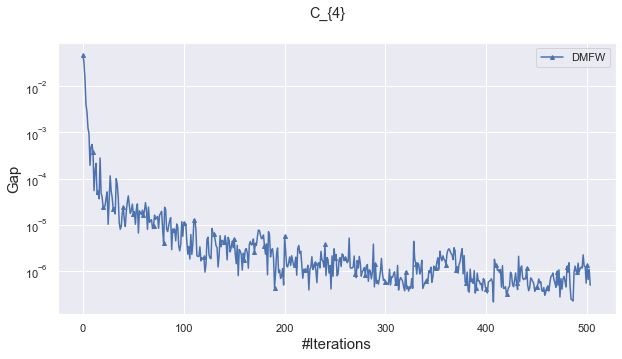

In [297]:
plt.figure(figsize=(10,5))
plt.suptitle("{}".format(cycle))
plt.plot(values_dmfw[:,0][:-1],values_dmfw[:,2][:-1], label='DMFW', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
#plt.ylim((1e-4, 1e0))
plt.yscale("log")
plt.xlabel("#Iterations",fontsize=15)
plt.ylabel("Gap",fontsize=15)

In [298]:
np.mean(values_dmfw[:,1][:-1])

0.025992783175463538

In [299]:
onlineloss = np.cumsum(values_dmfw[:,1][:-1])
arangement = np.arange(1,len(onlineloss)+1)
onlineloss = onlineloss/arangement

Text(0, 0.5, 'Loss')

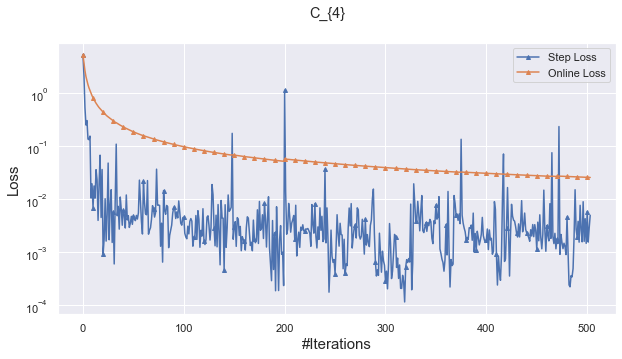

In [300]:
plt.figure(figsize=(10,5))
plt.suptitle("{}".format(cycle))
plt.plot(values_dmfw[:,0][:-1],values_dmfw[:,1][:-1], label='Step Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],onlineloss, label='Online Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
#plt.ylim((1e-3, 1e2))
plt.yscale("log")
plt.xlabel("#Iterations",fontsize=15)
plt.ylabel("Loss",fontsize=15)

# Prediction

In [301]:
def ModelPrediction(model_to_test, date ,loader, lookahead):
    prediction = []
    true = []
    for val, valpred in loader[date]:
        model_to_test.eval()
        pred = model_to_test(val)
        #print(pred.shape)
        prediction.append(pred.detach().numpy())
        true.append(valpred.detach().numpy())
    pred_array = np.asarray(prediction)
    true_array = np.asarray(true)
    #print(pred_array.shape)
    pred_shape = pred_array.shape
    #print(pred_shape)
    flattenTrue = true_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    flattenPred = pred_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    return flattenTrue, flattenPred

In [302]:
#torch.save(trainXMFW.models[3].state_dict(),"./OnlineModel/CNN1D/FINAL43_BestFinal/model3.pt")

In [303]:
model_trained = trainXMFW.best_models[0]
true, pred = ModelPrediction(model_trained,"2019-05-20", testloader[0], lookahead)

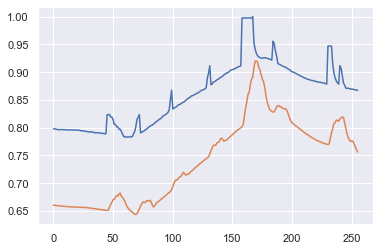

In [304]:
plt.plot(true) 
plt.plot(pred)

In [305]:
def PredictionMultipleDate(model, dates, date_begin, date_end, loader, lookahead, scalers, zone_name, ft_idx):
    predictTrue = []
    predictPred = []
    valuePD = pd.DataFrame()
    idx_begin = dates.index(date_begin)
    idx_end = dates.index(date_end)
    for date in dates[idx_begin:idx_end]:
        true, pred = ModelPrediction(model, date, loader, lookahead)
        maxi = scalers[zone_name].data_max_[ft_idx]
        mini = scalers[zone_name].data_min_[ft_idx]
        data_range = 0.8
        true = ((true.reshape(-1,1) - 0.2)*(maxi-mini))/data_range + mini
        pred = ((pred.reshape(-1,1) - 0.2)*(maxi-mini))/data_range + mini
        array = np.concatenate([true, pred],axis=1)
        result = pd.DataFrame({"Truth": true.squeeze(),
                              "Prediction" : pred.squeeze()})
                              #"Date": pd.date_range(start=date,periods=true.shape[0], freq="5min")})
        valuePD = pd.concat((valuePD, result)).reset_index(drop=True)
    return valuePD

In [306]:
floor_dict["Floor7Z1"].columns

Index(['ACPower', 'lightPower', 'appPower', 'temperature', 'humidity', 'lux'], dtype='object')

In [320]:
ft_idx = 3
indexroom = 3
mymodel = trainXMFW.best_models[indexroom]
real_index_zone = [1,2,4,5]
#testloader = [loaderZ1test]#, loaderZ2test, loaderZ4test, loaderZ5test]
may = [date for date in test_date if '2019-05' in date]
myfloor = ["Floor7Z1","Floor7Z2","Floor7Z4","Floor7Z5"]
resultpd = PredictionMultipleDate(mymodel,test_date,may[0], may[-1],testloader[indexroom], lookahead, scalers,
                                 myfloor[indexroom], ft_idx)

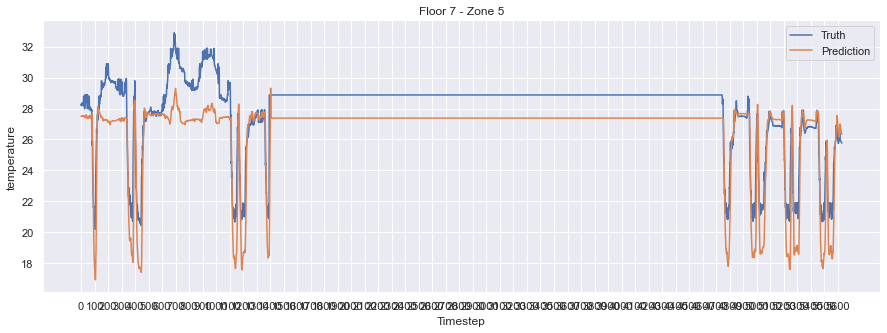

In [321]:
plt.figure(figsize=(15,5))
plt.title(f'Floor {floor} - Zone {real_index_zone[indexroom]}')
plt.plot(resultpd["Truth"],label="Truth")
plt.plot(resultpd["Prediction"],label="Prediction",ls='-')
plt.xticks(ticks=np.arange(resultpd.shape[0],step=100))
plt.legend()
plt.xlabel("Timestep")
plt.ylabel(f'{feature}')
plt.show()

In [322]:
pd.DataFrame.to_csv(resultpd,path_log+f'/prediction-zone{real_index_zone[indexroom]}.csv')

In [217]:
np.mean(resultpd["Truth"] - resultpd["Prediction"])

0.29539537

In [218]:
np.std(resultpd["Truth"] - resultpd["Prediction"])

2.5740945